In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Carga del archivo
data = pd.read_csv("./feature_engineering_work/dataset_feature_engineering.csv") 

# 1. Vista general
print(data.info())
print(data.describe())
print(data["is_fraud"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

In [23]:
# 2. Variables categóricas más relevantes
cat_vars = ['merchant', 'category', 'first_time_at_merchant']
for var in cat_vars:
    print(f"\n{var}:\n", data[var].value_counts().head())



merchant:
 merchant
fraud_Kilback LLC    6262
fraud_Cormier LLC    5246
fraud_Schumm PLC     5195
fraud_Kuhn LLC       5031
fraud_Boyer PLC      4999
Name: count, dtype: int64

category:
 category
gas_transport    188029
grocery_pos      176191
home             175460
shopping_pos     166463
kids_pets        161727
Name: count, dtype: int64

first_time_at_merchant:
 first_time_at_merchant
False    1323066
True      529328
Name: count, dtype: int64


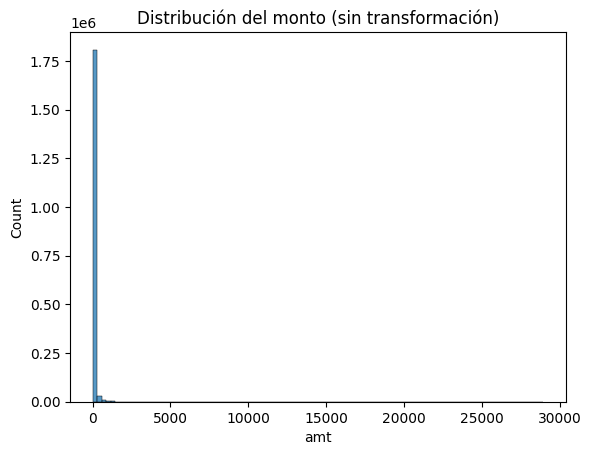

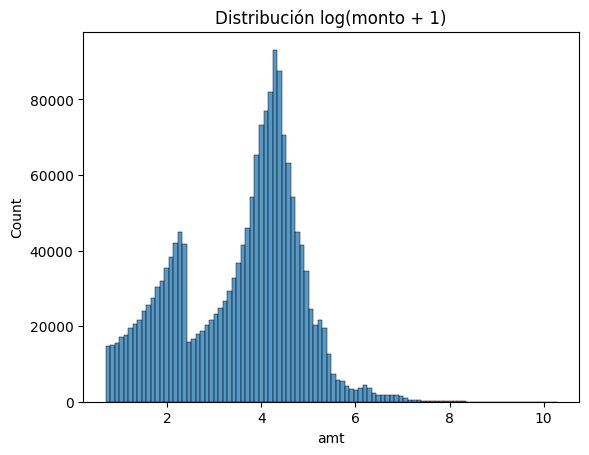

In [24]:
# 3. Distribuciones
sns.histplot(data['amt'], bins=100)
plt.title("Distribución del monto (sin transformación)")
plt.show()

# Log para corregir la asimetría
sns.histplot(np.log1p(data['amt']), bins=100)
plt.title("Distribución log(monto + 1)")
plt.show()


Debido a los datos obtenidos en la distribucion sin transformacion optamos por usar la transformacion logarítmica para la variable amt. Gracias a ello conseguimos:
- Reducir la asimetría de los valores grandes. 
- Hacer la distribución más cercana a una normal, lo que mejora el rendimiento del modelo. 
- Disminuir el impacto de valores atípicos (transacciones muy grandes).

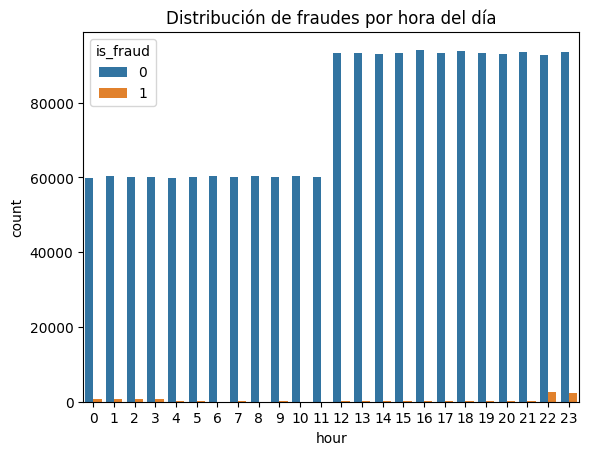

In [25]:
# 4. Fraude por hora
sns.countplot(x='hour', hue='is_fraud', data=data)
plt.title("Distribución de fraudes por hora del día")
plt.show()

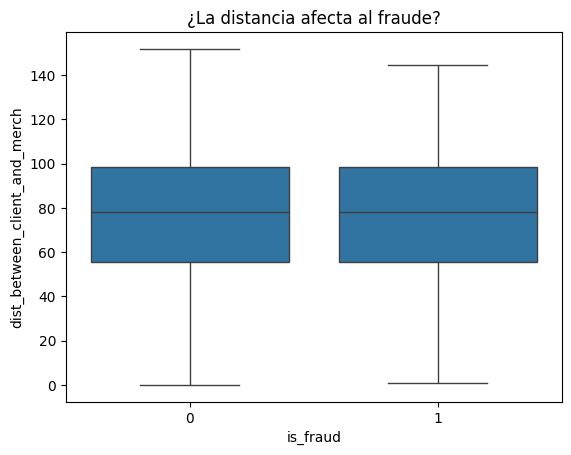

In [26]:
# 5. Distancia vs fraude
sns.boxplot(x='is_fraud', y='dist_between_client_and_merch', data=data)
plt.title("¿La distancia afecta al fraude?")
plt.show()

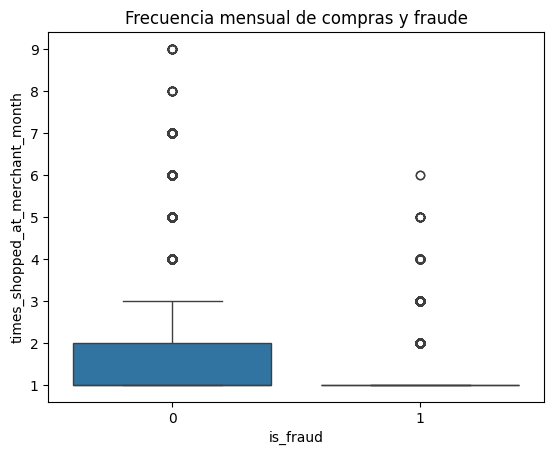

In [27]:
# 6. Frecuencia de compras en el comercio vs fraude
sns.boxplot(x='is_fraud', y='times_shopped_at_merchant_month', data=data)
plt.title("Frecuencia mensual de compras y fraude")
plt.show()

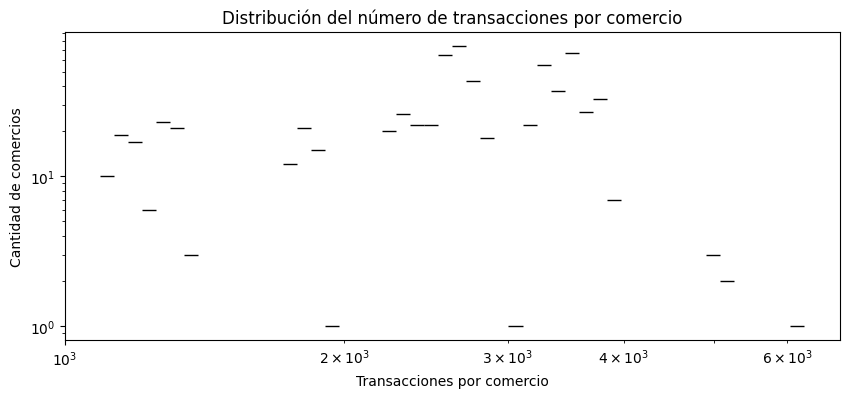

In [28]:
# 7. Umbral para detectar comercios con pocas transacciones
merchant_counts = data['merchant'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(merchant_counts, bins=50, log_scale=(True, True))
plt.title("Distribución del número de transacciones por comercio")
plt.xlabel("Transacciones por comercio")
plt.ylabel("Cantidad de comercios")
plt.show()


In [29]:
# 7. Comercios con pocas transacciones
# Calcular el número de transacciones por comercio
merchant_counts = data['merchant'].value_counts()

# Calcular el percentil 16.5 como umbral para baja frecuencia
percentil_16 = np.percentile(merchant_counts, 16.5)

print(f"Umbral (percentil 16.5) para baja frecuencia: {percentil_16:.2f} transacciones")

# Identificar comercios de baja frecuencia
low_freq_merchants = merchant_counts[merchant_counts < percentil_16].index
low_freq_data = data[data['merchant'].isin(low_freq_merchants)].copy()

Umbral (percentil 16.5) para baja frecuencia: 1784.72 transacciones


In [30]:
# Cantidad del fraude ocurre en comercios de baja frecuencia
fraudes_baja_frecuencia = data[data['merchant'].isin(low_freq_merchants) & (data['is_fraud'] == 1)]
print("Fraudes en comercios de baja frecuencia:", len(fraudes_baja_frecuencia))

Fraudes en comercios de baja frecuencia: 694


In [31]:
# Cantidad que no son fraude en comercios de baja frecuencia
fraudes_baja_frecuencia = data[data['merchant'].isin(low_freq_merchants) & (data['is_fraud'] == 0)]
print("No son fraudes en comercios de baja frecuencia:", len(fraudes_baja_frecuencia))

No son fraudes en comercios de baja frecuencia: 149210


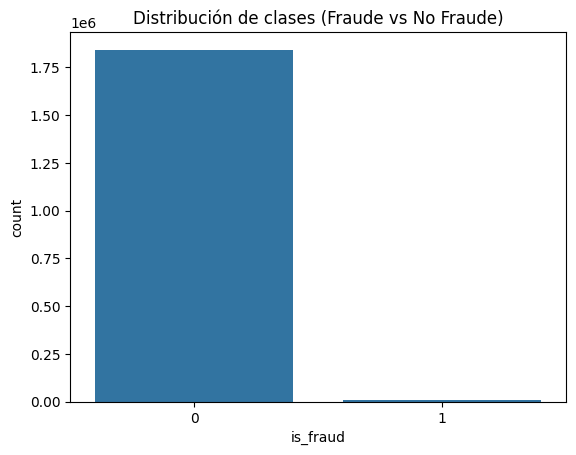

In [32]:
# Balanceo de clases
sns.countplot(x='is_fraud', data=data)
plt.title("Distribución de clases (Fraude vs No Fraude)")
plt.show()


## Ingeniería de Características enfocadas en el problema

El objetivo en el proyecto es mejorar la detección en comercios con pocas transacciones por lo que generaremos nuevas features útiles para este caso.

In [33]:
# 1. ¿Es comercio de baja frecuencia?
# Agregar el conteo de transacciones por comercio a cada fila
low_freq_data['merchant_transaction_count'] = low_freq_data.groupby('merchant')['cc_num'].transform('count')

# Etiquetar si el comercio es de baja frecuencia
low_freq_data['is_low_freq_merchant'] = low_freq_data['merchant_transaction_count'] < percentil_16

# 2. Diferencia entre la media mensual del usuario vs esta transacción
low_freq_data['amt_vs_month_mean'] = low_freq_data['amt'] - (low_freq_data['amt_month'] / low_freq_data['times_shopped_at_merchant_month'].replace(0, np.nan))

# 3. Hora sospechosa (madrugada)
low_freq_data['is_night'] = low_freq_data['hour'].apply(lambda x: 1 if x < 6 else 0)

# 4. Distancia anómala (z-score por usuario)
low_freq_data['client_mean_dist'] = low_freq_data.groupby('cc_num')['dist_between_client_and_merch'].transform('mean')
low_freq_data['dist_zscore'] = (low_freq_data['dist_between_client_and_merch'] - low_freq_data['client_mean_dist']) / (
    low_freq_data.groupby('cc_num')['dist_between_client_and_merch'].transform('std').replace(0, np.nan)
)

# 5. Cambio brusco de gasto (z-score mensual)
low_freq_data['amt_zscore'] = (low_freq_data['amt'] - low_freq_data.groupby('cc_num')['amt'].transform('mean')) / (
    low_freq_data.groupby('cc_num')['amt'].transform('std').replace(0, np.nan)
)

### Division Train/Test Dataset

In [34]:
# Separar datos de test (diciembre 2020)
train_df = low_freq_data[~((low_freq_data['year'] == 2020) & (low_freq_data['trans_month'] == 12))]
test_df = low_freq_data[(low_freq_data['year'] == 2020) & (low_freq_data['trans_month'] == 12)]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (138609, 42)
Test shape: (11295, 42)


In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separar características y etiquetas
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']

# Identificar columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Codificar columnas categóricas con LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le

# Imputar valores faltantes con la media (para variables numéricas)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Balanceo con SMOTE
n_class_0 = y_train.value_counts()[0]
sampling_strategy = 0.2

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

# Verificación
print("Train shape (balanced):", X_train_balanced.shape)
print("Distribución de clases en el conjunto balanceado:")
print(pd.Series(y_train_balanced).value_counts())


Train shape (balanced): (165516, 41)
Distribución de clases en el conjunto balanceado:
is_fraud
0    137930
1     27586
Name: count, dtype: int64


### Entrenamiento del modelo Base (LightGBM)

### Metricas personalizadas

In [36]:
def custom_fp_ratio(preds, train_data):
    y_true = train_data.get_label()
    preds_binary = (preds >= 0.5).astype(int)
    TP = np.sum((preds_binary == 1) & (y_true == 1))
    FP = np.sum((preds_binary == 1) & (y_true == 0))
    ratio = (TP + FP) / TP if TP != 0 else np.inf
    return 'fp_ratio', ratio, False

In [37]:
def custom_low_volume_recall(preds, train_data):
    y_true = train_data.get_label()
    pred_binary = (preds >= 0.5).astype(int)

    TP = np.sum((pred_binary == 1) & (y_true == 1))
    FN = np.sum((pred_binary == 0) & (y_true == 1))

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return 'recall', recall, True


In [38]:
def custom_balanced_low_volume_score(preds, train_data):
    y_true = train_data.get_label()
    pred_binary = (preds >= 0.5).astype(int)

    TP = np.sum((pred_binary == 1) & (y_true == 1))
    FP = np.sum((pred_binary == 1) & (y_true == 0))
    FN = np.sum((pred_binary == 0) & (y_true == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return 'balanced_f1', f1, True

In [39]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, stratify=y_train_balanced, random_state=42
)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42
}
fevals = {
    'fp_ratio': custom_fp_ratio,
    'low_volume_recall': custom_low_volume_recall,
    'low_volume_f1': custom_balanced_low_volume_score
}

lgb_train = lgb.Dataset(X_train_split, label=y_train_split)
lgb_val = lgb.Dataset(X_val_split, label=y_val_split)

models = {}
results = {}

for name, feval in fevals.items():
    print(f"\nEntrenando con métrica personalizada: {name}")
    
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_val],
        feval=feval,
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=10)
        ]
    )
    
    models[name] = model

    # Evaluación con predict()
    val_preds = model.predict(X_val_split)
    val_pred_labels = (val_preds >= 0.5).astype(int)

    TP = ((val_pred_labels == 1) & (y_val_split == 1)).sum()
    FP = ((val_pred_labels == 1) & (y_val_split == 0)).sum()
    FN = ((val_pred_labels == 0) & (y_val_split == 1)).sum()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    fp_ratio = (TP + FP) / (TP + 1e-6)

    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'FP Ratio': fp_ratio
    }

results_df = pd.DataFrame(results).T.sort_values(by='Recall', ascending=False)
print(results_df)



Entrenando con métrica personalizada: fp_ratio
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.991522	valid_0's fp_ratio: 1.00059
Early stopping, best iteration is:
[9]	valid_0's auc: 0.991117	valid_0's fp_ratio: 1

Entrenando con métrica personalizada: low_volume_recall
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.991522	valid_0's recall: 0.617727
[20]	valid_0's auc: 0.995022	valid_0's recall: 0.903752
[30]	valid_0's auc: 0.996641	valid_0's recall: 0.935653
[40]	valid_0's auc: 0.998382	valid_0's recall: 0.951604
[50]	valid_0's auc: 0.999353	valid_0's recall: 0.962842
[60]	valid_0's auc: 0.999608	valid_0's recall: 0.973536
[70]	valid_0's auc: 0.999727	valid_0's recall: 0.980243
[80]	valid_0's auc: 0.999791	valid_0's recall: 0.983687
[90]	valid_0's auc: 0.999854	valid_0's recall: 0.988218
[100]	valid_0's auc: 0.999869	valid_0's recall: 0.9913
[110]	valid_0's auc: 0.999885	valid_0's recall: 0.993112
[120]	valid_0's

Seleccionamos low_volume_f1 como métrica personalizada para LightGBM.

Justificación:

Tiene excelente recall (>99%), superando el umbral de 90% que se pide para detección de fraude.

Mantiene un FP ratio bajo (casi 1), lo que indica pocos falsos positivos adicionales.

El F1-score es la métrica balanceada que combina precisión y recall, adecuada para tu objetivo de balance.

En la práctica, minimiza falsos positivos sin sacrificar detección de fraude, cumpliendo con el requisito.

In [40]:
import numpy as np
import pandas as pd

# Función auxiliar para calcular métricas clásicas y FP ratio en test
def evaluate_on_test(model, X_test, y_test):
    preds_proba = model.predict(X_test)
    preds_binary = (preds_proba >= 0.5).astype(int)
    
    TP = np.sum((preds_binary == 1) & (y_test == 1))
    FP = np.sum((preds_binary == 1) & (y_test == 0))
    FN = np.sum((preds_binary == 0) & (y_test == 1))
    
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    fp_ratio = (TP + FP) / (TP + 1e-6)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'FP Ratio': fp_ratio
    }

# Diccionario para guardar resultados en test
test_results = {}
# Extraer X_test y y_test de test_df
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']
print("Distribución real en test (y_test):")
print(y_test.value_counts())

# Transformar columnas categóricas usando los label_encoders ya fit
for col in categorical_cols:
    le = label_encoders[col]
    # Convertir a string para evitar problemas
    X_test[col] = X_test[col].astype(str)
    # Crear un array con los valores codificados o -1 si no está en las clases
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Imputar valores faltantes en test usando el imputer entrenado en train
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

for name, model in models.items():
    print(f"Evaluando modelo con métrica personalizada: {name} en test")
    results = evaluate_on_test(model, X_test_imputed, y_test)
    print(f"Resultados para {name}: {results}")
    test_results[name] = results
    
# Mostrar resultados ordenados por recall (o por FP ratio, según prefieras)
test_results_df = pd.DataFrame(test_results).T.sort_values(by='Recall', ascending=False)
print(test_results_df)

Distribución real en test (y_test):
is_fraud
0    11280
1       15
Name: count, dtype: int64
Evaluando modelo con métrica personalizada: fp_ratio en test
Resultados para fp_ratio: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0), 'FP Ratio': np.float64(0.0)}
Evaluando modelo con métrica personalizada: low_volume_recall en test
Resultados para low_volume_recall: {'Precision': np.float64(0.9090908264462886), 'Recall': np.float64(0.6666666222222252), 'F1-score': np.float64(0.7692302218938036), 'FP Ratio': np.float64(1.099999890000011)}
Evaluando modelo con métrica personalizada: low_volume_f1 en test
Resultados para low_volume_f1: {'Precision': np.float64(0.8333332638888947), 'Recall': np.float64(0.6666666222222252), 'F1-score': np.float64(0.7407401920442281), 'FP Ratio': np.float64(1.199999880000012)}
                   Precision    Recall  F1-score  FP Ratio
low_volume_recall   0.909091  0.666667   0.76923       1.1
low_volume_f1       0.833333  0.66